In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from random import uniform
from numpy.random import normal
from matplotlib import animation


In [2]:
np.arctan2(0, 1)

0.0

In [3]:
G = 10**(-21)  # Gravitational constant
AU = 149.6e6 # Astronomical unit in km
M = 1.989 * 10 ** 30 # Solar mass in kg
R_sol = 6.963 * 10 ** 5 # Solar radius in km




In [10]:
class Gravity():

    def __init__(self):
        self.type = 'Gravitational Potential'
        

    def _V(self, object1, object2):
        m1 = object1.m
        m2 = object2.m

        r = np.sqrt((object1.x - object2.x)**2 + (object1.y - object2.y)**2)
        V = - G * m1 * m2 / r
        return V

    def _dV_dr(self, r, m_prod):
        
        dV_dr = G * m_prod / r**2
        return dV_dr

    def energy(self, positions): 
        return np.sum(self._V(pdist(positions)))

    def force(self, planets):
        pos = np.array([[planet.x, planet.y] for planet in planets])    
        diff = pos[np.newaxis, :, :] - pos[:, np.newaxis, :]
       
        ms = np.array([planet.m for planet in planets])
        m_prod = ms[:, np.newaxis] * ms[np.newaxis, :]
        np.fill_diagonal(m_prod, 0)

        r = np.sqrt(np.sum(diff**2, axis=-1))
        np.fill_diagonal(r, np.inf)
        force_magnitude = self._dV_dr(r, m_prod)
        forces = np.sum(force_magnitude[..., np.newaxis] * diff / r[..., np.newaxis], axis=1)
        return forces


class Planet():

    def __init__(self, r, v, m, R, color, name = None):
        theta = np.random.uniform(0, 2*np.pi)
        r = r/AU
        v = v/AU
        m = m/M
        R = R**(1/3) * 1e3
        self.x = r * np.cos(theta)
        self.y = r * np.sin(theta)
        self.vx = v * np.cos(theta + np.pi/2)
        self.vy = v * np.sin(theta + np.pi/2)
        self.m = m
        self.R = R/R_sol
        self.color = color
        if name is None:
            self.name = str(id(self))
        else:
            self.name = name


class SolarSystem():

    def __init__(self, planets, calculator = Gravity()):

        
        self.calculator = calculator
        Sun = {"distance_km": 0, "velocity_kms": 0, "radius_km": 696340, "mass_kg": 1.989 * 10 ** 30, "color": "yellow"}
        Sun = Planet(Sun["distance_km"], Sun["velocity_kms"], Sun["mass_kg"], Sun["radius_km"], Sun["color"], "Sun")
        
        self.planets = [Sun, *planets]
        self.static = [False for _ in range(len(self.planets))]
        self.static[0] = True
        self.filter = np.array([self.static, self.static]).T


    def get_positions(self):
        return np.array([[planet.x, planet.y] for planet in self.planets])

    def set_positions(self, positions):
        for i, planet in enumerate(self.planets):
            planet.x, planet.y = positions[i]

    def get_velocities(self):
        return np.array([[planet.vx, planet.vy] for planet in self.planets])

    def set_velocities(self, velocities):
        for i, planet in enumerate(self.planets):
            planet.vx, planet.vy = velocities[i]


    def velocity_verlet(self, dt):

        pos = self.get_positions()
        vel = self.get_velocities()
        acc = self.forces() 

        pos_new = pos + vel * dt + 0.5 * acc * dt**2
        self.set_positions(pos_new)

        acc_new = self.forces() 
        vel_new = vel + 0.5 * (acc + acc_new) * dt
        self.set_velocities(vel_new)

    def forces(self):
        forces = self.calculator.force(self.planets)
        return np.where(self.filter,0,forces)

    def draw(self, ax):
        for planet in self.planets:
            
            ax.add_patch(plt.Circle((planet.x, planet.y), planet.R, color=planet.color))
        







In [11]:
planets = {
    "Mercury": {
        "distance_km": 57.9e6,
        "velocity_kms": 47.87/2,
        "radius_km": 2439.7,
        "mass_kg": 3.3011e23,
        "color": "grey"
    },
    "Venus": {
        "distance_km": 108.2e6,
        "velocity_kms": 35.02/2,
        "radius_km": 6051.8,
        "mass_kg": 4.8675e24,
        "color": "brown"
    },
    "Earth": {
        "distance_km": 149.6e6,
        "velocity_kms": 29.78/2,
        "radius_km": 6371,
        "mass_kg": 5.97237e24,
        "color": "tab:blue"
    },
    "Mars": {
        "distance_km": 227.9e6,
        "velocity_kms": 24.07/1.5,
        "radius_km": 3389.5,
        "mass_kg": 6.4171e23,
        "color": "red"
    },
    "Jupiter": {
        "distance_km": 778.5e6,
        "velocity_kms": 13.07,
        "radius_km": 69911,
        "mass_kg": 1.8982e27,
        "color": "orange"
    },
    "Saturn": {
        "distance_km": 1.434e9,
        "velocity_kms": 9.69,
        "radius_km": 58232,
        "mass_kg": 5.6834e26,
        "color": "yellow"
    },
    "Uranus": {
        "distance_km": 2.871e9,
        "velocity_kms": 6.81,
        "radius_km": 25362,
        "mass_kg": 8.6810e25,
        "color": "cyan"
    },
    "Neptune": {
        "distance_km": 4.495e9,
        "velocity_kms": 5.43,
        "radius_km": 24622,
        "mass_kg": 1.02413e26,
        "color": "blue"
    }
}

Sun = {"distance_km": 0, "velocity_kms": 0, "radius_km": R_sol, "mass_kg": M, "color": "yellow"}
Sun = Planet(Sun["distance_km"], Sun["velocity_kms"], Sun["mass_kg"], Sun["radius_km"], Sun["color"], "Sun")

solar_system = [Sun]

for planet in planets:
    planets[planet] = Planet(
        planets[planet]["distance_km"],
        planets[planet]["velocity_kms"],
        planets[planet]["mass_kg"],
        planets[planet]["radius_km"],
        planets[planet]["color"],
        planet
    )
   

planets




{'Mercury': <__main__.Planet at 0x2e0499cfb90>,
 'Venus': <__main__.Planet at 0x2e049a9bfe0>,
 'Earth': <__main__.Planet at 0x2e049a9b560>,
 'Mars': <__main__.Planet at 0x2e049a9b770>,
 'Jupiter': <__main__.Planet at 0x2e049a9a210>,
 'Saturn': <__main__.Planet at 0x2e049a99940>,
 'Uranus': <__main__.Planet at 0x2e049a988c0>,
 'Neptune': <__main__.Planet at 0x2e049a98590>}

[[  0.          -0.        ]
 [ -0.38587378  -0.0299209 ]
 [  0.43060052  -0.581112  ]
 [  0.98783829   0.15548476]
 [  0.04913639  -1.52260308]
 [  5.0634037    1.20094914]
 [ -5.29146794  -7.99270644]
 [-19.06596472   2.18866254]
 [-28.17857077  10.42966084]]


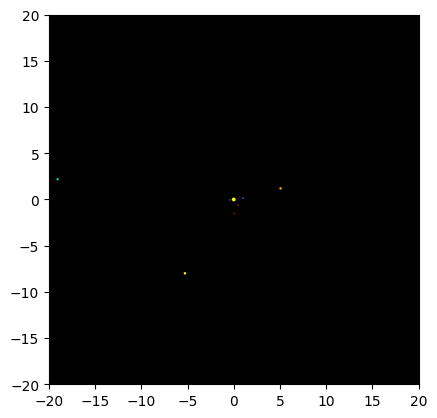

In [14]:
solar_system = SolarSystem([*planets.values()])



fig, ax = plt.subplots()


solar_system.draw(ax)

print(solar_system.get_positions())

ax.set(xlim=(-20, 20), ylim = (-20, 20), aspect='equal')
ax.set_facecolor('black')
ax.set(xlabel='AU', ylabel='AU')


In [15]:
def update(i):
    solar_system.velocity_verlet(0.05e7)
    ax.clear()
    solar_system.draw(ax)
    ax.set(xlim=(-20, 20), ylim = (-20, 20), aspect='equal')
ani = animation.FuncAnimation(fig, update, frames=50, repeat=True)
ani.save('solarsystem.gif', writer='pillow', fps=60)